<a href="https://colab.research.google.com/github/CIA-Oceanix/DLGD2022/blob/main/lecture-4-dl-oi-da/notebooks/notebookPyTorch_InvProb_LearningBased_UnrollingFixedPoint_L63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import tensorflow.keras as keras

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition
from sklearn.feature_extraction import image


In [2]:
!pip install torchviz
import torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=a55de644f3df41eac291836891cb68e2cacf4e6dab9d445f0fe9e29c8badd0aa
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


In [3]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 30.3 MB/s 
     |████████████████████████████████| 512 kB 70.4 MB/s 
     |████████████████████████████████| 125 kB 69.8 MB/s 
     |████████████████████████████████| 87 kB 8.6 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=7967a88b92cea1ee164c4c9cd9146f60486e3e3a9aca35d0e3ba78e9bbac3a87
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire


In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/4dvarnet')
!pwd

Mounted at /content/drive
/content/drive/My Drive/4dvarnet


# L63 Data simulation

........ Data generation
........ Random seed set to 100
(20000, 3)


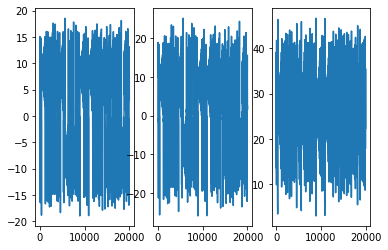

In [4]:
#os.chdir('/content/drive/My Drive/Colab Notebooks/AnDA')
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#from AnDA_codes.AnDA_dynamical_models import AnDA_Lorenz_63, AnDA_Lorenz_96

print('........ Data generation')
flagRandomSeed = 0
if flagRandomSeed == 0:
    print('........ Random seed set to 100')
    np.random.seed(100)
    torch.manual_seed(100)

def AnDA_Lorenz_63(S,t,sigma,rho,beta):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0]);
    x_2 = S[0]*(rho-S[2])-S[1];
    x_3 = S[0]*S[1] - beta*S[2];
    dS  = np.array([x_1,x_2,x_3]);
    return dS

class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho   = 28.0
        beta  = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8 # number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1,2]) # indices of the observed variables
    nb_loop_train = 10**2 # size of the catalog
    nb_loop_test = 20000 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation

class time_series:
  values = 0.
  time   = 0.
  
## data generation: L63 series
GD = GD()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(GD.dt_integration,GD.nb_loop_test*GD.dt_integration+0.000001,GD.dt_integration)
#S = odeint(AnDA_Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta));
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=np.arange(0,5+0.000001,GD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[GD.dt_integration,GD.nb_loop_test+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()


print(S.shape)
plt.figure(1)
for jj in range(0,3):
  plt.subplot(131+jj)
  plt.plot(S[:,jj])
  
class time_series:
  values = 0.
  time   = 0.
  
xt = time_series()
xt.values = S
xt.time   = tt

In [6]:
####################################################
## Generation of training and test dataset
## Extraction of time series of dT time steps            
NbTraining = 10000
NbTest     = 2000#256
time_step = 1
dT        = 200
sigNoise  = 0.#np.sqrt(2.0)
rateMissingData = (1-1./8.)#0.75#0.95
  
xt = time_series()
xt.values = S
xt.time   = tt
# extract subsequences
dataTrainingNoNaN = image.extract_patches_2d(xt.values[0:12000:time_step,:],(dT,3),max_patches=NbTraining)
dataTestNoNaN     = image.extract_patches_2d(xt.values[15000::time_step,:],(dT,3),max_patches=NbTest)

# create missing data
flagTypeMissData = 2
if flagTypeMissData == 0:
    print('..... Observation pattern: Random sampling of osberved L63 components')
    indRand         = np.random.permutation(dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTraining    = np.copy(dataTrainingNoNaN).reshape((dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2],1))
    dataTraining[indRand] = float('nan')
    dataTraining    = np.reshape(dataTraining,(dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2]))
    
    indRand         = np.random.permutation(dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2])
    indRand         = indRand[0:int(rateMissingData*len(indRand))]
    dataTest        = np.copy(dataTestNoNaN).reshape((dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2],1))
    dataTest[indRand] = float('nan')
    dataTest          = np.reshape(dataTest,(dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2]))

    genSuffixObs    = '_ObsRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
elif flagTypeMissData == 2:
    print('..... Observation pattern: Only the first L63 component is osberved')
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTraining[:,::time_step_obs,0] = dataTrainingNoNaN[:,::time_step_obs,0]
    
    dataTest    = np.zeros((dataTestNoNaN.shape))
    dataTest[:] = float('nan')
    dataTest[:,::time_step_obs,0] = dataTestNoNaN[:,::time_step_obs,0]

    genSuffixObs    = '_ObsDim0_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
   
else:
    print('..... Observation pattern: All  L63 components osberved')
    time_step_obs   = int(1./(1.-rateMissingData))
    dataTraining    = np.zeros((dataTrainingNoNaN.shape))
    dataTraining[:] = float('nan')
    dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
    
    dataTest    = np.zeros((dataTestNoNaN.shape))
    dataTest[:] = float('nan')
    dataTest[:,::time_step_obs,:] = dataTestNoNaN[:,::time_step_obs,:]

    genSuffixObs    = '_ObsSub_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
    
# set to NaN patch boundaries
dataTraining[:,0:10,:] =  float('nan')
dataTest[:,0:10,:]     =  float('nan')
dataTraining[:,dT-10:dT,:] =  float('nan')
dataTest[:,dT-10:dT,:]     =  float('nan')

# mask for NaN
maskTraining = (dataTraining == dataTraining).astype('float')
maskTest     = ( dataTest    ==  dataTest   ).astype('float')

dataTraining = np.nan_to_num(dataTraining)
dataTest     = np.nan_to_num(dataTest)

# Permutation to have channel as #1 component
dataTraining      = np.moveaxis(dataTraining,-1,1)
maskTraining      = np.moveaxis(maskTraining,-1,1)
dataTrainingNoNaN = np.moveaxis(dataTrainingNoNaN,-1,1)

dataTest      = np.moveaxis(dataTest,-1,1)
maskTest      = np.moveaxis(maskTest,-1,1)
dataTestNoNaN = np.moveaxis(dataTestNoNaN,-1,1)

# set to NaN patch boundaries
#dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
#dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]

############################################
## raw data
X_train         = dataTrainingNoNaN
X_train_missing = dataTraining
mask_train      = maskTraining

X_test         = dataTestNoNaN
X_test_missing = dataTest
mask_test      = maskTest

############################################
## normalized data
meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 
stdTr           = np.sqrt( np.mean( (X_train_missing-meanTr)**2 ) / np.mean(mask_train) )

if flagTypeMissData == 2:
    meanTr          = np.mean(X_train[:]) 
    stdTr           = np.sqrt( np.mean( (X_train-meanTr)**2 ) )

x_train_missing = ( X_train_missing - meanTr ) / stdTr
x_test_missing  = ( X_test_missing - meanTr ) / stdTr

# scale wrt std

x_train = (X_train - meanTr) / stdTr
x_test  = (X_test - meanTr) / stdTr

print('.... MeanTr = %.3f --- StdTr = %.3f '%(meanTr,stdTr))

# Generate noisy observsation
X_train_obs = X_train_missing + sigNoise * maskTraining * np.random.randn(X_train_missing.shape[0],X_train_missing.shape[1],X_train_missing.shape[2])
X_test_obs  = X_test_missing  + sigNoise * maskTest * np.random.randn(X_test_missing.shape[0],X_test_missing.shape[1],X_test_missing.shape[2])

x_train_obs = (X_train_obs - meanTr) / stdTr
x_test_obs  = (X_test_obs - meanTr) / stdTr

print('..... Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('..... Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))


..... Observation pattern: Only the first L63 component is osberved
.... MeanTr = 8.715 --- StdTr = 13.587 
..... Training dataset: 10000x3x200
..... Test dataset    : 2000x3x200


<ipython-input-7-31b783ea93ba>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_obs[ X_train_obs == 0. ] = np.float('NaN')


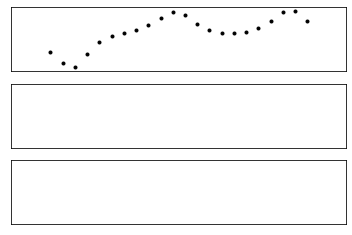

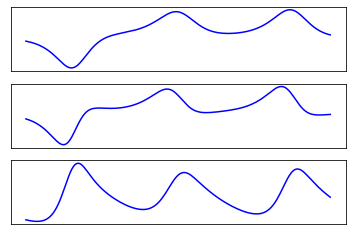

In [7]:
X_train_obs[ X_train_obs == 0. ] = np.float('NaN')
# Visualisation
plt.figure(1)
for jj in range(0,3):
  indjj = 311+jj
  f_ = plt.subplot(indjj)
  plt.plot(X_train[20,jj,:],'w-')
  plt.plot(X_train_obs[20,jj,:],'k.')
  f_.get_xaxis().set_visible(False)
  f_.get_yaxis().set_visible(False)
  #plt.ylim

plt.figure(2)
for jj in range(0,3):
  indjj = 311+jj
  f_ = plt.subplot(indjj)
  plt.plot(X_train[20,jj,:],'b-')
  #plt.plot(X_train_obs[20,jj,:],'k.')
  f_.get_xaxis().set_visible(False)
  f_.get_yaxis().set_visible(False)


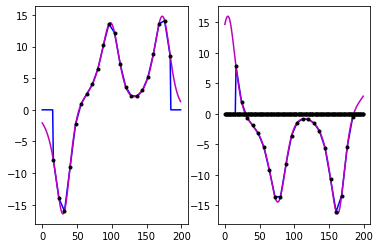

In [8]:
# Initial interpolation (linear interpolation or zeros) for missing data

import scipy

mx_train = np.sum( np.sum( X_train , axis = 2 ) , axis = 0 ) / (X_train.shape[0]*X_train.shape[2])

flagInit = 1

if flagInit == 0: 
  X_train_Init = mask_train * X_train_obs + (1. - mask_train) * (np.zeros(X_train_missing.shape) + meanTr)
  X_test_Init  = mask_test * X_test_obs + (1. - mask_test) * (np.zeros(X_test_missing.shape) + meanTr)
else:
  X_train_Init = np.zeros(X_train.shape)
  for ii in range(0,X_train.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_train.shape[1],X_train.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_train[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_train[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_train_obs[ii,kk,indt])
        XInit[kk,indt]  = X_train_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit[kk,:] = XInit[kk,:] + mx_train[kk]

    X_train_Init[ii,:,:] = XInit

  X_test_Init = np.zeros(X_test.shape)
  for ii in range(0,X_test.shape[0]):
    # Initial linear interpolation for each component
    XInit = np.zeros((X_test.shape[1],X_test.shape[2]))

    for kk in range(0,3):
      indt  = np.where( mask_test[ii,kk,:] == 1.0 )[0]
      indt_ = np.where( mask_test[ii,kk,:] == 0.0 )[0]

      if len(indt) > 1:
        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
        fkk = scipy.interpolate.interp1d(indt, X_test_obs[ii,kk,indt])
        XInit[kk,indt]  = X_test_obs[ii,kk,indt]
        XInit[kk,indt_] = fkk(indt_)
      else:
        XInit[kk,:] = XInit[kk,:] + mx_train[kk]

    X_test_Init[ii,:,:] = XInit


x_train_Init = ( X_train_Init - meanTr ) / stdTr
x_test_Init = ( X_test_Init - meanTr ) / stdTr


if 1*1:
  plt.figure()
  plt.subplot(1,2,1)
  plt.plot(X_train_Init[20,0,:],'b-')
  plt.plot(X_train[20,0,:],'m-')
  #plt.plot(XInit[:,0],'r-')
  plt.plot(X_train_obs[20,0,:],'k.')
  plt.subplot(1,2,2)
  plt.plot(X_test_Init[20,0,:],'b-')
  plt.plot(X_test[20,0,:],'m-')
  #plt.plot(XInit[:,0],'r-')
  plt.plot(X_test_obs[20,0,:],'k.')

In [9]:
# reshape to 2D tensors to use 
# the 2D implementation of the 4DVarNet
x_train = x_train.reshape((-1,3,dT,1))
mask_train = mask_train.reshape((-1,3,dT,1))
x_train_Init = x_train_Init.reshape((-1,3,dT,1))
x_train_obs = x_train_obs.reshape((-1,3,dT,1))

x_test = x_test.reshape((-1,3,dT,1))
mask_test = mask_test.reshape((-1,3,dT,1))
x_test_Init = x_test_Init.reshape((-1,3,dT,1))
x_test_obs = x_test_obs.reshape((-1,3,dT,1))

print('..... Training dataset: %dx%dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2],x_train.shape[3]))
print('..... Test dataset    : %dx%dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2],x_test.shape[3]))

..... Training dataset: 10000x3x200x1
..... Test dataset    : 2000x3x200x1


# Direct learning-based scheme for missing data interpolation with a CNN

In [10]:
shapeData  = x_train.shape[1:]
DimAE = 10
dW = 3
class Phi_r(torch.nn.Module):
    def __init__(self):
        super(Phi_r, self).__init__()
        self.conv1  = torch.nn.Conv2d(shapeData[0],shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
        self.conv2  = torch.nn.Conv2d(shapeData[0]*DimAE,2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
        self.conv3  = torch.nn.Conv2d(2*shapeData[0]*DimAE,4*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
        self.conv4  = torch.nn.Conv2d(4*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)

    def forward(self, xinp):
        x = self.conv1( xinp )
        x = self.conv2( F.relu(x) )
        x = self.conv3( F.relu(x) )
        x = self.conv4( x )

        return x


In [11]:
import pytorch_lightning as pl

class LitModel_CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # main model
        self.lr = 1e-3
        self.model        = Phi_r()
        self.x_rec    = None # variable to store output of test method
        self.curr = 0
        
    def forward(self):
        return 1

    def configure_optimizers(self):
        optimizer   = optim.Adam([{'params': self.model.parameters(), 'lr': self.lr},
                                    ], lr=0.)
        return optimizer
    
        
    def on_train_epoch_start(self):
        opt = self.optimizers()
        
    def training_step(self, train_batch, batch_idx, optimizer_idx=0):
        opt = self.optimizers()
                    
        # compute loss and metrics
        loss, out, metrics = self.compute_loss(train_batch, phase='train')
                
        self.log("tr_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
                 
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        loss, out, metrics = self.compute_loss(val_batch, phase='val')

        self.log('val_loss', stdTr**2 * metrics['mse'] )
        self.log("val_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        loss, out, metrics = self.compute_loss(test_batch, phase='test')

        self.log("test_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return {'preds': out.detach().cpu()}

    def test_epoch_end(self, outputs):
        x_test_rec = torch.cat([chunk['preds'] for chunk in outputs]).numpy()
        x_test_rec = stdTr * x_test_rec + meanTr        
        self.x_rec = x_test_rec.squeeze()

        return [{'mse':0.,'preds': 0.}]

    def compute_loss(self, batch, phase ):

        inputs_init,inputs_obs,masks,targets_GT = batch
 
            
        with torch.set_grad_enabled(True):
            outputs = self.model( inputs_init )
            
            loss = torch.mean((outputs - targets_GT) ** 2)
            
            # metrics
            mse       = loss.detach()
            metrics   = dict([('mse',mse)])
            #print(mse.cpu().detach().numpy())
            if (phase == 'val') or (phase == 'test'):                
                outputs = outputs.detach()
                
        return loss,outputs, metrics

In [39]:
# Pytorch dataloadzers
from pytorch_lightning.callbacks import ModelCheckpoint

UsePriodicBoundary = False # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
w_loss = np.ones(dT) / np.float(dT)
batch_size = 128
idx_val = x_train.shape[0]-500


training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init[:idx_val:,:,:,:]),torch.Tensor(x_train_obs[:idx_val:,:,:,:]),torch.Tensor(mask_train[:idx_val:,:,:,:]),torch.Tensor(x_train[:idx_val:,:,:,:])) # create your datset
val_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init[idx_val::,:,:,:]),torch.Tensor(x_train_obs[idx_val::,:,:,:]),torch.Tensor(mask_train[idx_val::,:,:,:]),torch.Tensor(x_train[idx_val::,:,:,:])) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Create LitModel
mod = LitModel_CNN()

suffix_exp = 'exp%02d'%flagTypeMissData
filename_chkpt = 'modelCNN-l63-'
    
filename_chkpt = filename_chkpt + suffix_exp

checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath= './resL63/'+suffix_exp,
                                      filename= filename_chkpt + '-{epoch:02d}-{val_loss:.2f}',
                                      save_top_k=3,
                                      mode='min')


<ipython-input-39-9500b370cc9c>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  w_loss = np.ones(dT) / np.float(dT)


In [40]:
# Training from scratch
logger = pl.loggers.CSVLogger('logs', name='direct_inversion_l63')

mod.lr   = 1e-3
profiler_kwargs = {'max_epochs': 50 }
trainer = pl.Trainer(gpus=1,  
                     **profiler_kwargs,
                     callbacks=[checkpoint_callback],
                      logger=logger)
trainer.fit(mod, dataloaders['train'], dataloaders['val'])


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /content/resL63/exp02 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Logs stored at logs/direct_inversion_l63/version_1/metrics.csv


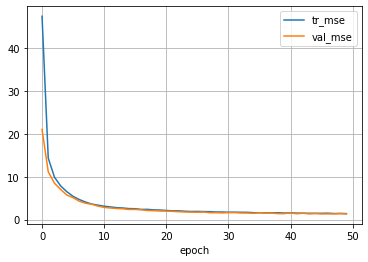

In [41]:
import pandas as pd 

print(f"Logs stored at {logger.log_dir}/metrics.csv")
## Plot metrics
(
    pd.read_csv(f'{logger.log_dir}/metrics.csv') .groupby('epoch').mean()
    [['tr_mse', 'val_mse']].plot(grid=True)
)

In [42]:
# Check saved checlpoints
#!rm -f resL63/exp02/*CNN*
!ls  resL63/exp02/*CNN*

'resL63/exp02/modelCNN-l63-exp02-epoch=07-val_loss=6.00.ckpt'
'resL63/exp02/modelCNN-l63-exp02-epoch=08-val_loss=6.02.ckpt'
'resL63/exp02/modelCNN-l63-exp02-epoch=09-val_loss=6.00.ckpt'
'resL63/exp02/modelCNN-l63-exp02-epoch=43-val_loss=1.32.ckpt'
'resL63/exp02/modelCNN-l63-exp02-epoch=45-val_loss=1.31.ckpt'
'resL63/exp02/modelCNN-l63-exp02-epoch=49-val_loss=1.31.ckpt'


In [43]:
pathCheckPOint = './resL63/exp02/modelCNN-l63-exp02-epoch=49-val_loss=1.31.ckpt'
print('.... load pre-trained model :'+pathCheckPOint)

mod = LitModel_CNN.load_from_checkpoint(pathCheckPOint)            

profiler_kwargs = {'max_epochs': 1}
trainer = pl.Trainer(gpus=1,  **profiler_kwargs)

############################################################
# metrics for validation dataset
trainer.test(mod, dataloaders['val'])

X_val = X_train[idx_val::,:,:]
mask_val = mask_train[idx_val::,:,:,:].squeeze()
var_val  = np.mean( (X_val - np.mean(X_val,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_val) **2 ) 
mse_i   = np.mean( (1.-mask_val.squeeze()) * (mod.x_rec-X_val) **2 ) / np.mean( (1.-mask_val) )
mse_r   = np.mean( mask_val.squeeze() * (mod.x_rec-X_val) **2 ) / np.mean( mask_val )

nmse = mse / var_val
nmse_i = mse_i / var_val
nmse_r = mse_r / var_val

print("..... Assimilation performance (validation data)")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))

trainer.test(mod, dataloaders['test'])

############################################################
# metrics for test dataset
var_test  = np.mean( (X_test - np.mean(X_test,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_test) **2 ) 
mse_i   = np.mean( (1.-mask_test.squeeze()) * (mod.x_rec-X_test) **2 ) / np.mean( (1.-mask_test) )
mse_r   = np.mean( mask_test.squeeze() * (mod.x_rec-X_test) **2 ) / np.mean( mask_test )

nmse = mse / var_test
nmse_i = mse_i / var_test
nmse_r = mse_r / var_test

print("..... Assimilation performance (test data)")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


.... load pre-trained model :./resL63/exp02/modelCNN-l63-exp02-epoch=49-val_loss=1.31.ckpt


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse            1.3118031024932861
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
..... Assimilation performance (validation data)
.. MSE ALL.   : 1.312 / 0.019
.. MSE ObsData: 0.093 / 0.001
.. MSE Interp : 1.358 / 0.020


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse             1.322740912437439
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
..... Assimilation performance (test data)
.. MSE ALL.   : 1.323 / 0.018
.. MSE ObsData: 0.098 / 0.001
.. MSE Interp : 1.369 / 0.019


..... Assimilation performance
.. MSE ALL.   : 1.323 / 0.018
.. MSE ObsData: 0.098 / 0.001
.. MSE Interp : 1.369 / 0.019


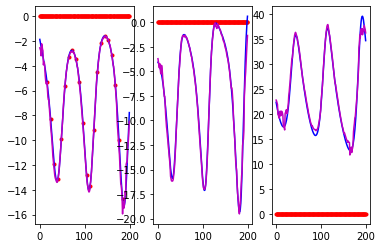

In [44]:
ii = 110

mod.x_rec = mod.x_rec.squeeze()
x_gt  = X_test[ii,:,:]
x_rec = mod.x_rec[ii,:,:]
y_obs = X_test_obs[ii,:,:]

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(y_obs[kk,:],'r.')
  plt.plot(x_gt[kk,:],'b-')
  plt.plot(x_rec[kk,:],'m-')

# Reconstruction performance
var_test  = np.mean( (X_test - np.mean(X_test,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_test) **2 ) 
mse_i   = np.mean( (1.-mask_test.squeeze()) * (mod.x_rec-X_test) **2 ) / np.mean( (1.-mask_test) )
mse_r   = np.mean( mask_test.squeeze() * (mod.x_rec-X_test) **2 ) / np.mean( mask_test )

nmse = mse / var_test
nmse_i   = mse_i / var_test
nmse_r   = mse_r / var_test

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))

# Trainable projection-based prior $\Phi$



In [24]:
flagAEType = 'unet'
DimAE = 10
shapeData  = x_train.shape[1:]

if flagAEType == 'ode': ## ode_L63

    class Phi_r(torch.nn.Module):
        def __init__(self):
              super(Phi_r, self).__init__()
              self.sigma = torch.nn.Parameter(torch.Tensor([np.random.randn()]))
              self.rho    = torch.nn.Parameter(torch.Tensor([np.random.randn()]))
              self.beta   = torch.nn.Parameter(torch.Tensor([np.random.randn()]))

              self.sigma  = torch.nn.Parameter(torch.Tensor([10.]))
              self.rho    = torch.nn.Parameter(torch.Tensor([28.]))
              self.beta   = torch.nn.Parameter(torch.Tensor([8./3.]))

              self.dt        = 0.01
              self.IntScheme = 'rk4'
              self.stdTr     = stdTr
              self.meanTr    = meanTr                      
        def _odeL63(self, xin):
            x1  = xin[:,0,:]
            x2  = xin[:,1,:]
            x3  = xin[:,2,:]
            
            dx_1 = (self.sigma*(x2-x1)).view(-1,1,xin.size(2))
            dx_2 = (x1*(self.rho-x3)-x2).view(-1,1,xin.size(2))
            dx_3 = (x1*x2 - self.beta*x3).view(-1,1,xin.size(2))
            
            dpred = torch.cat((dx_1,dx_2,dx_3),dim=1)
            return dpred

        def _EulerSolver(self, x):
            return x + self.dt * self._odeL63(x)

        def _RK4Solver(self, x):
            k1 = self._odeL63(x)
            x2 = x + 0.5 * self.dt * k1
            k2 = self._odeL63(x2)
          
            x3 = x + 0.5 * self.dt * k2
            k3 = self._odeL63(x3)
              
            x4 = x + self.dt * k3
            k4 = self._odeL63(x4)

            return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.
      
        def forward(self, x):
            X = self.stdTr * x.view(-1,x.size(1),x.size(2))
            X = X + self.meanTr
            
            if self.IntScheme == 'euler':
                xpred = self._EulerSolver( X[:,:,0:x.size(2)-1] )
            else:
                xpred = self._RK4Solver( X[:,:,0:x.size(2)-1] )

            xpred = xpred - self.meanTr
            xpred = xpred / self.stdTr

            xnew  = torch.cat((x[:,:,0].view(-1,x.size(1),1),xpred),dim=2)
            
            xnew = xnew.view(-1,x.size(1),x.size(2),1)
            
            return xnew

elif flagAEType == 'unet': ## Conv model with no use of the central point
  dW = 5
  class Phi_r(torch.nn.Module):
      def __init__(self):
          super(Phi_r, self).__init__()
          self.pool1  = torch.nn.AvgPool2d((4,1))
          self.conv1  = torch.nn.Conv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
          self.conv2  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
          self.conv21 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv22 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv23 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.conv3  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)

          self.conv2Tr = torch.nn.ConvTranspose2d(shapeData[0]*DimAE,shapeData[0],(4,1),stride=(4,1),bias=False)          

          self.convHR1  = torch.nn.Conv2d(shapeData[0],2*shapeData[0]*DimAE,(2*dW+1,1),padding=(dW,0),bias=False)
          self.convHR2  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          
          self.convHR21 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.convHR22 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.convHR23 = torch.nn.Conv2d(shapeData[0]*DimAE,shapeData[0]*DimAE,1,padding=0,bias=False)
          self.convHR3  = torch.nn.Conv2d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)

      def forward(self, xinp):
          x = self.pool1( xinp )
          x = self.conv1( x )
          x = self.conv2( F.relu(x) )
          x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
          x = self.conv3( x )
          x = self.conv2Tr( x )
          
          xHR = self.convHR1( xinp )
          xHR = self.convHR2( F.relu(xHR) )
          xHR = torch.cat((self.convHR21(xHR), self.convHR22(xHR) * self.convHR23(xHR)),dim=1)
          xHR = self.convHR3( xHR )
          
          x   = torch.add(x,1.,xHR)
          
          x = x.view(-1,shapeData[0],shapeData[1],1)
          return x


# Lightning Class for the unrolling of a fixed-point algorithm

In [25]:
class HParam_FixedPoint:
    def __init__(self):
        self.n_iter_fp       = 1
        self.k_n_fp       = 1

        self.alpha_proj    = 0.5
        self.alpha_mse = 1.
        self.lr = 1.e-3


In [27]:
EPS_NORM_GRAD = 0. * 1.e-20  
import pytorch_lightning as pl

class LitModel_FixedPoint(pl.LightningModule):
    def __init__(self,conf=HParam_FixedPoint(),*args, **kwargs):
        super().__init__()
        self.save_hyperparameters()

        # hyperparameters
        self.hparams.n_iter_fp    = 5
        self.hparams.k_n_fp        = 1
                
        self.hparams.alpha_prior    = 0.5
        self.hparams.alpha_mse = 1.e1        
        self.hparams.lr    = 1.e-3

        # main model
        self.model        = Phi_r()
        self.x_rec    = None # variable to store output of test method
        self.x_rec_obs = None
        self.curr = 0
        

    def forward(self):
        return 1

    def configure_optimizers(self):
        optimizer   = optim.Adam([{'params': self.model.parameters(), 'lr': self.hparams.lr},
                                    ], lr=0.)
        return optimizer
    
        
    def on_train_epoch_start(self):
        opt = self.optimizers()
        
    def training_step(self, train_batch, batch_idx, optimizer_idx=0):
        opt = self.optimizers()
                    
        # compute loss and metrics
        loss, out, metrics = self.compute_loss(train_batch, phase='train')
        
        for kk in range(0,self.hparams.k_n_fp-1):
            loss1, out, metrics = self.compute_loss(train_batch, phase='train',batch_init=out)
            loss = loss + loss1
        
        self.log("tr_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
                 
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        loss, out, metrics = self.compute_loss(val_batch, phase='val')
        for kk in range(0,self.hparams.k_n_fp-1):
            loss1, out, metrics = self.compute_loss(val_batch, phase='val',batch_init=out)
            loss = loss1

        self.log('val_loss', stdTr**2 * metrics['mse'] )
        self.log("val_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        loss, out, metrics = self.compute_loss(test_batch, phase='test')
        
        for kk in range(0,self.hparams.k_n_fp-1):
            loss1, out, metrics = self.compute_loss(test_batch, phase='test',batch_init=out)

        self.log("test_mse", stdTr**2 * metrics['mse'] , on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return {'preds': out.detach().cpu()}

    def test_epoch_end(self, outputs):
        x_test_rec = torch.cat([chunk['preds'] for chunk in outputs]).numpy()
        x_test_rec = stdTr * x_test_rec + meanTr        
        self.x_rec = x_test_rec.squeeze()

        return [{'mse':0.,'preds': 0.}]

    def compute_loss(self, batch, phase, batch_init = None ):

        inputs_init_,inputs_obs,masks,targets_GT = batch
 
        if batch_init is None :
            inputs_init = inputs_init_
        else:
            inputs_init = batch_init
            
        if phase == 'train' :                
            inputs_init = inputs_init.detach()
            
        with torch.set_grad_enabled(True):
            outputs = inputs_init
            
            for kk in range(0,self.hparams.n_iter_fp-1):
               outputs = inputs_obs * masks + (1. - masks) * self.model( outputs ) 
            outputs = self.model( outputs ) 

            loss_mse = torch.mean((outputs - targets_GT) ** 2)
            loss_prior = torch.mean((self.model(outputs) - outputs) ** 2)
            loss_prior_gt = torch.mean((self.model(targets_GT) - targets_GT) ** 2)

            loss = self.hparams.alpha_mse * loss_mse
            loss += 0.5 * self.hparams.alpha_prior * (loss_prior + loss_prior_gt)
            
            # metrics
            mse       = loss_mse.detach()
            metrics   = dict([('mse',mse)])
            #print(mse.cpu().detach().numpy())
            if (phase == 'val') or (phase == 'test'):                
                outputs = outputs.detach()
                
        return loss,outputs, metrics

# Model training 

In [35]:
# Pytorch dataloadzers
from pytorch_lightning.callbacks import ModelCheckpoint

batch_size = 128
idx_val = x_train.shape[0]-500


training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init[:idx_val:,:,:,:]),torch.Tensor(x_train_obs[:idx_val:,:,:,:]),torch.Tensor(mask_train[:idx_val:,:,:,:]),torch.Tensor(x_train[:idx_val:,:,:,:])) # create your datset
val_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_train_Init[idx_val::,:,:,:]),torch.Tensor(x_train_obs[idx_val::,:,:,:]),torch.Tensor(mask_train[idx_val::,:,:,:]),torch.Tensor(x_train[idx_val::,:,:,:])) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_Init),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}


mod = LitModel_FixedPoint()

suffix_exp = 'exp%02d'%flagTypeMissData
filename_chkpt = 'modelFP-l63-'

filename_chkpt = filename_chkpt+flagAEType+'-'  
    
filename_chkpt = filename_chkpt + suffix_exp
filename_chkpt = filename_chkpt+'-ifp%02d_%02d'%(mod.hparams.n_iter_fp,mod.hparams.k_n_fp)

checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath= './resL63/'+suffix_exp,
                                      filename= filename_chkpt + '-{epoch:02d}-{val_loss:.2f}',
                                      save_top_k=3,
                                      mode='min')


In [36]:
# Training from scratch
logger = pl.loggers.CSVLogger('logs', name='unrolling_fixedpooint_l63') 

mod.hparams.n_iter_fp       = 5
mod.hparams.k_n_fp          = 2
mod.hparams.lr              = 1e-3

mod.hparams.alpha_prior = 0.1
mod.hparams.alpha_mse = 1.

filename_chkpt = filename_chkpt+flagAEType+'-'  
filename_chkpt = filename_chkpt + suffix_exp
filename_chkpt = filename_chkpt+'-ifp%02d_%02d'%(mod.hparams.n_iter_fp,mod.hparams.k_n_fp)
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath= './resL63/'+suffix_exp,
                                      filename= filename_chkpt + '-{epoch:02d}-{val_loss:.2f}',
                                      save_top_k=3,
                                      mode='min')



profiler_kwargs = {'max_epochs': 10 }

trainer = pl.Trainer(gpus=1,  **profiler_kwargs,
                     callbacks=[checkpoint_callback],
                     logger=logger)
trainer.fit(mod, dataloaders['train'], dataloaders['val'])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | Phi_r | 15.3 K
--------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Logs stored at logs/unrolling_fixedpooint_l63/version_2/metrics.csv


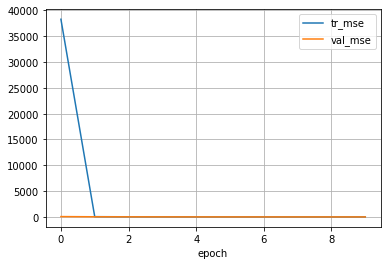

In [37]:
import pandas as pd 

print(f"Logs stored at {logger.log_dir}/metrics.csv")
## Plot metrics
(
    pd.read_csv(f'{logger.log_dir}/metrics.csv') .groupby('epoch').mean()
    [['tr_mse', 'val_mse']].plot(grid=True)
)

# Model testing

In [38]:
# Check saved checlpoints
#!rm -f resL63/exp02/*CNN*
!ls  resL63/exp02/*FP*

'resL63/exp02/modelFP-l63-unet-exp02-ifp05_01unet-exp02-ifp05_02-epoch=07-val_loss=4.32.ckpt'
'resL63/exp02/modelFP-l63-unet-exp02-ifp05_01unet-exp02-ifp05_02-epoch=07-val_loss=9.78.ckpt'
'resL63/exp02/modelFP-l63-unet-exp02-ifp05_01unet-exp02-ifp05_02-epoch=08-val_loss=4.13.ckpt'
'resL63/exp02/modelFP-l63-unet-exp02-ifp05_01unet-exp02-ifp05_02-epoch=08-val_loss=9.27.ckpt'
'resL63/exp02/modelFP-l63-unet-exp02-ifp05_01unet-exp02-ifp05_02-epoch=09-val_loss=3.31.ckpt'
'resL63/exp02/modelFP-l63-unet-exp02-ifp05_01unet-exp02-ifp05_02-epoch=09-val_loss=8.83.ckpt'
'resL63/exp02/modelFP-l63-unet-exp02-ifp05_01unet-exp02-ifp05_02-epoch=46-val_loss=2.14.ckpt'
'resL63/exp02/modelFP-l63-unet-exp02-ifp05_01unet-exp02-ifp05_02-epoch=47-val_loss=2.04.ckpt'
'resL63/exp02/modelFP-l63-unet-exp02-ifp05_01unet-exp02-ifp05_02-epoch=49-val_loss=2.04.ckpt'


In [32]:
pathCheckPOint = 'resL63/exp02/modelFP-l63-unet-exp02-ifp05_02-epoch=49-val_loss=2.04.ckpt'
print('.... load pre-trained model :'+pathCheckPOint)

mod = LitModel_FixedPoint.load_from_checkpoint(pathCheckPOint)            

#print(mod.hparams)
mod.hparams.n_iter_fp       = 5
mod.hparams.k_n_fp          = 2

profiler_kwargs = {'max_epochs': 1}
trainer = pl.Trainer(gpus=1,  **profiler_kwargs)

############################################################
# metrics for validation dataset
trainer.test(mod, test_dataloaders=dataloaders['val'])

X_val = X_train[idx_val::,:,:]
mask_val = mask_train[idx_val::,:,:,:].squeeze()
var_val  = np.mean( (X_val - np.mean(X_val,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_val) **2 ) 
mse_i   = np.mean( (1.-mask_val.squeeze()) * (mod.x_rec-X_val) **2 ) / np.mean( (1.-mask_val) )
mse_r   = np.mean( mask_val.squeeze() * (mod.x_rec-X_val) **2 ) / np.mean( mask_val )

nmse = mse / var_val
nmse_i = mse_i / var_val
nmse_r = mse_r / var_val

print("..... Assimilation performance (validation data)")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))

trainer.test(mod, test_dataloaders=dataloaders['test'])

############################################################
# metrics for test dataset
var_test  = np.mean( (X_test - np.mean(X_test,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_test) **2 ) 
mse_i   = np.mean( (1.-mask_test.squeeze()) * (mod.x_rec-X_test) **2 ) / np.mean( (1.-mask_test) )
mse_r   = np.mean( mask_test.squeeze() * (mod.x_rec-X_test) **2 ) / np.mean( mask_test )

nmse = mse / var_test
nmse_i = mse_i / var_test
nmse_r = mse_r / var_test

print("..... Assimilation performance (test data)")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))        

.... load pre-trained model :resL63/exp02/modelFP-l63-unet-exp02-ifp05_02-epoch=49-val_loss=2.04.ckpt


FileNotFoundError: ignored

..... Assimilation performance
.. MSE ALL.   : 0.625 / 0.009
.. MSE ObsData: 0.233 / 0.003
.. MSE Interp : 0.640 / 0.009


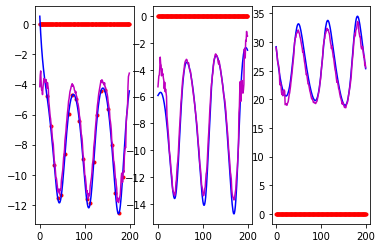

In [ ]:
ii = 110

mod.x_rec = mod.x_rec.squeeze()
x_gt  = X_test[ii,:,:]
x_rec = mod.x_rec[ii,:,:]
y_obs = X_test_obs[ii,:,:]

## visualization
plt.figure()
for kk in range(0,3):
  plt.subplot(1,3,kk+1)
  plt.plot(y_obs[kk,:],'r.')
  plt.plot(x_gt[kk,:],'b-')
  plt.plot(x_rec[kk,:],'m-')

# Reconstruction performance
var_test  = np.mean( (X_test - np.mean(X_test,axis=0))**2 )
mse = np.mean( (mod.x_rec-X_test) **2 ) 
mse_i   = np.mean( (1.-mask_test.squeeze()) * (mod.x_rec-X_test) **2 ) / np.mean( (1.-mask_test) )
mse_r   = np.mean( mask_test.squeeze() * (mod.x_rec-X_test) **2 ) / np.mean( mask_test )

nmse = mse / var_test
nmse_i   = mse_i / var_test
nmse_r   = mse_r / var_test

print("..... Assimilation performance")
print(".. MSE ALL.   : %.3f / %.3f"%(mse,nmse))
print(".. MSE ObsData: %.3f / %.3f"%(mse_r,nmse_r))
print(".. MSE Interp : %.3f / %.3f"%(mse_i,nmse_i))

In [ ]:
!python main_4DVarNet_L63.py

........ Data generation
........ Random seed set to 100
..... Observation pattern: Only the first L63 component is osberved
.... MeanTr = 8.435 --- StdTr = 13.687 
..... Training dataset: 10000x3x200
..... Test dataset    : 2000x3x200
..... Training dataset: 10000x3x200x1
..... Test dataset    : 2000x3x200x1
........ Define AE architecture
 AE Model/Dynamical prior: _GENN_4_10_05
Phi_r(
  (encoder): Encoder(
    (pool1): AvgPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0)
    (conv1): Conv2d(3, 60, kernel_size=(11, 1), stride=(1, 1), padding=(5, 0), bias=False)
    (conv2): Conv2d(60, 30, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv21): Conv2d(30, 30, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv22): Conv2d(30, 30, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv23): Conv2d(30, 30, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv3): Conv2d(60, 30, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv2Tr): ConvTranspose2d(30, 3, kernel_size